In [34]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [35]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn

In [36]:
df = pd.read_csv(r'C:\Users\User\Documents\dataset.csv')

In [37]:
apple_close = df['AAPL'].dropna()
apple_close = apple_close.astype('float32')

In [38]:
apple_close

0         7.643214
1         7.656429
2         7.534643
3         7.520714
4         7.570714
           ...    
3791    227.179993
3792    228.029999
3793    226.490005
3794    229.789993
3795    229.000000
Name: AAPL, Length: 3690, dtype: float32

In [39]:
maxdf = apple_close.max()

In [40]:
mindf = apple_close.min()

In [41]:
apple_close = (apple_close - apple_close.min()) / (apple_close.max()-apple_close.min())

In [42]:
lookback = 60
train_dataset=[]
y_dataset = []
for i in range(len(apple_close)):
    if len(apple_close.iloc[i:60+i])==lookback:
        train_dataset.append(apple_close.iloc[i:60+i].values)
        try:
            y_dataset.append(apple_close.iloc[60+i])
        except:
            pass
    else:
        pass

In [43]:
x = torch.tensor(train_dataset)
y = torch.tensor(y_dataset)

In [44]:
train_split = int(x.shape[0]*0.8)

In [45]:
x_train = x[:train_split]
x_test = x[train_split:-1]

y_train = y[:train_split].reshape(len(x_train),1)
y_test = y[train_split:].reshape(len(x_test),1)

In [46]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=60, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32,1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = self.linear2(x)
        return x

In [47]:
import torch.optim as optim
import torch.utils.data as data

In [74]:
class DirectionalLoss(nn.Module):
    def __init__(self):
        super(DirectionalLoss, self).__init__()

    def forward(self, predictions, targets):
        # Centering the data
        predictions_centered = predictions - torch.mean(predictions)
        targets_centered = targets - torch.mean(targets)

        # Computing the numerator as dot product of centered predictions and targets
        numerator = torch.sum(predictions_centered * targets_centered)

        # Computing the denominator as product of their norms
        denominator = torch.sqrt(torch.sum(predictions_centered ** 2)) * torch.sqrt(torch.sum(targets_centered ** 2))

        # Avoiding division by zero
        if denominator == 0:
            return torch.tensor(0.0, requires_grad=True)

        # Correlation coefficient
        correlation = numerator / denominator

        # Negative correlation for loss (as we want to maximize the correlation)
        loss = -correlation
        return loss

In [96]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=False, batch_size=16)

In [106]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(x_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train MSE 0.0187, test MSE 0.0240
Epoch 100: train MSE 0.0316, test MSE 0.0660
Epoch 200: train MSE 0.0445, test MSE 0.0978
Epoch 300: train MSE 0.0396, test MSE 0.0275
Epoch 400: train MSE 0.0268, test MSE 0.0295
Epoch 500: train MSE 0.0547, test MSE 0.0878
Epoch 600: train MSE 0.0536, test MSE 0.1432
Epoch 700: train MSE 0.0600, test MSE 0.1145
Epoch 800: train MSE 0.0514, test MSE 0.0927
Epoch 900: train MSE 0.0407, test MSE 0.0927


In [107]:
y_pred = model(x_test).detach().numpy()
y_pred = y_pred*(maxdf-mindf) + mindf

In [108]:
y_pred = y_pred.reshape(-1)

In [109]:
y_tes = (apple_close[-726:].values)*(maxdf-mindf) + mindf

In [110]:
from sklearn.metrics import mean_absolute_error

In [111]:
mean_absolute_error(y_pred,y_tes)

10.669985

In [112]:
y_pred[-4:]

array([234.10172, 233.57993, 234.56392, 234.91316], dtype=float32)

In [113]:
y_tes[-4:]

array([228.03, 226.49, 229.79, 229.  ], dtype=float32)

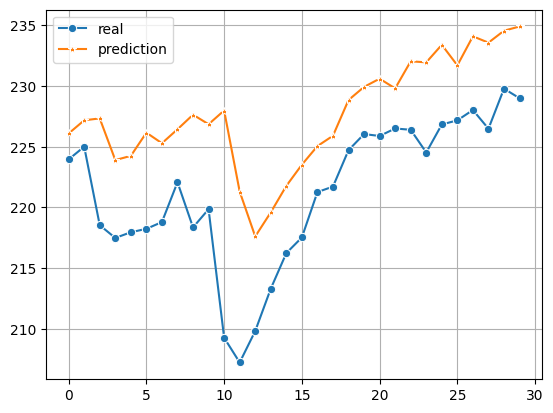

In [114]:
sns.lineplot(y_tes[-30:],label='real',marker='o')
sns.lineplot(y_pred[-30:],label='prediction',marker='*')

plt.grid()
plt.legend()
plt.show()